In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

color_default = 'firebrick'

In [2]:
! pip install emcee corner pyro-ppl tqdm seaborn

     |████████████████████████████████| 45 kB 1.4 MB/s 
     |████████████████████████████████| 713 kB 10.5 MB/s 


In [3]:
! pip install --upgrade daft

  Attempting uninstall: daft
    Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4


In [4]:
# Fix seed for reproducibility

import random
import torch
import pyro

SEED = 192

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
pyro.set_rng_seed(SEED)

# An introduction to probabilistic programming with Pyro and PyTorch

**Siddharth Mishra-Sharma** (smsharma@mit.edu)

A self-contained version of this notebook can be run on Google Colab at https://colab.research.google.com/drive/1UNSZsDy_Ma9-rNerE-YQHB-dFxef4vmq#scrollTo=kHx_1M7--ME_&forceEdit=true&sandboxMode=true.

## 1. What is probabilistic programming? <a name="introduction"></a>

### 1.1. Probabilistic modeling as storytelling

- One way to look at defining probabilistic models: telling a story about how you think your data came about
- Many scientific observations of interest can be described in terms of simulators
- Simulators execute a series of stochastic steps to produce a realization of the dataset of interest---**simulators are probabilistic programs**

<img src="https://raw.githubusercontent.com/smsharma/smsharma/master/lhc.png#" alt="LHC Schematic" width="800"/>

$$\theta \sim p(\theta)$$
$$\mathrm{parton} \sim p(\mathrm{parton}\mid\theta)$$
$$\mathrm{shower} \sim p(\mathrm{shower}\mid\mathrm{parton})$$
$$\mathrm{detector} \sim p(\mathrm{detector}\mid\mathrm{shower})$$
$$x \sim p(x\mid \mathrm{detector})$$

After writing our forward model as a probabilistic program, we can then use inference algorithms to 'invert' the process and get the Bayesian posterior $p(\theta\mid x)$ for a given observation

### 1.2. Probabilistic programming languages (PPLs)

- Probabilistic programming languages (PPLs) realize this paradigm by treating (random) variables and distributions as first-class objects, allowing us to
    - Compose probabilistic models in terms of distributions of random variables
    - Perform inference on models by them conditioning on observations

A biased sample of PPLs, with different design philosophies and inference engines:
- [Pyro](https://pyro.ai/)/[NumPyro](https://num.pyro.ai/en/stable/): based on PyTorch/JAX with strengths in variational inference and MCMC respectively
- [PyMC3](https://docs.pymc.io/en/v3/): a solid general-purpose PPL in Python
- [Turing.jl](https://turing.ml/stable/): based on Julia
- [Tensorflow Probability](https://www.tensorflow.org/probability): based on Tensorflow

Being based on differentiable framework, they make it easy to use gradient-based optimization for inference.

## 2. A familiar example

We will start by playing around with the familiar supernova dataset that we've seen a few time before. Let's download, load and plot it.

In [5]:
import urllib.request

# Download the SN data file
url = 'https://stash.osgconnect.net/public/dleon/CosmoMC/data/sn_z_mu_dmu_plow_union2.1.txt'
urllib.request.urlretrieve(url, './sn_z_mu_dmu_plow_union2.1.txt')

('./sn_z_mu_dmu_plow_union2.1.txt',
 <http.client.HTTPMessage at 0x7f275622b510>)

In [6]:
data = np.genfromtxt('sn_z_mu_dmu_plow_union2.1.txt')

zs = data.T[1]  # Redshift
mm = data.T[2]  # Difference between apparent and absolute magnitude
dm = data.T[3]  # Its uncertainty

# Get distance modulus and its uncertainty
d = 10. ** (mm / 5. + 1.) / 1e6  
derr = 10. ** ((mm + dm) / 5. + 1. - 6.) - d

c = 3e5  # Speed of light

In [7]:
print("Dataset consists of {} data points".format(len(d)))

Dataset consists of 580 data points


Text(0, 0.5, 'Distance\\,[Mpc]')

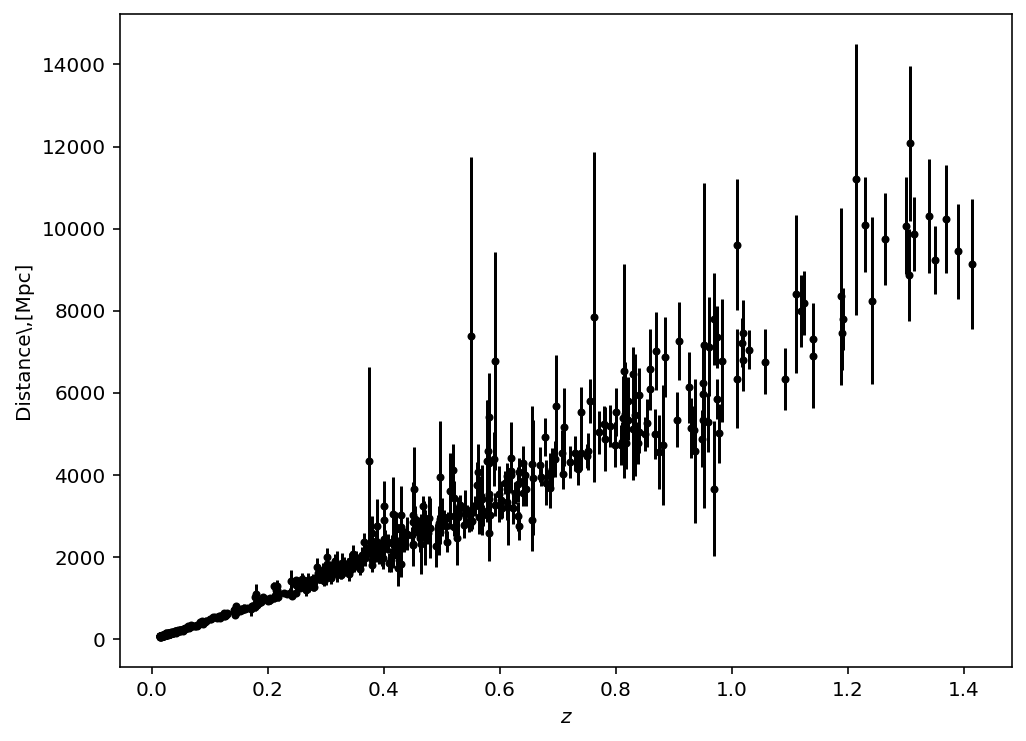

In [8]:
plt.figure(figsize=(8,6))

plt.errorbar(zs, d, yerr=derr, marker='.', ls='None', color='k')
plt.xlabel(r"$z$")
plt.ylabel(r"Distance\,[Mpc]")

As before, we'll use this dataset to infer the hubble parameter $H_0$, as well as an additional parameter $q$, historically called the deceleration parameter. $q_0 < 0$ corresponds to an accelerating universe, $q_0 > 0$ a decelerating universe (see https://en.wikipedia.org/wiki/Deceleration_parameter for further details).

The theoretical distance modulus prediction can be computed as 
$$ d = \frac{c}{H_0}\left(z + \frac{1}{2}(1 - q_0) \, z^2\right)$$

In [9]:
z_max = 0.5  # Maximum redshift up to which to use data

### 2.1. Weighted least squares

We'll start with a simple weighted least squares approach using `scipy.optimize.minimize`, which should be familiar. We write down a likelihood, and use the optimizer to obtain the maximum-likelihood estimate (MLE) by minimizing the (negative) log-likelihood.

In [10]:
from scipy.optimize import minimize

In [11]:
def d_pred(z, H0, q0):
    """ Predicted distance modulus
    """
    return c / H0 * (z + 0.5 * (1 - q0) * z ** 2)

In [12]:
def log_likelihood(theta, x, y, yerr):
    """ Gaussian log-likelihood of dist. mod. given H0 and deceleration parameter q
    """
    H0, q0 = theta
    y_pred = d_pred(x, H0, q0)
    ll = -0.5 * np.sum((y - y_pred) ** 2 / yerr ** 2)
    return ll

In [13]:
nll = lambda *args: -log_likelihood(*args)
soln = minimize(nll, [70, 0.5], bounds=[[1e-5,100],[-2., 2.]], args=(zs[zs < z_max], d[zs < z_max], derr[zs < z_max]), )
H0_mle, q0_mle = soln.x

In [14]:
print("MLE estimates are H0 = {}, q0 = {}".format(H0_mle, q0_mle))

MLE estimates are H0 = 70.30968896980929, q0 = -0.4097328553308003


### 2.2. MCMC with `emcee`

Next, we'll do traditional MCMC with `emcee`, which should again be familiar. Here, we draw samples from a log-probability distribution, with the samples then being representative of the joint posterior on the two parameters of interest.

In [15]:
import emcee
import corner

In [16]:
def log_prob(theta, x, y, y_err):
        
    H0, q0 = theta
        
    # Prior contribution
    
    lp = 0
    if not 10. < H0 < 100. and not -5. < q0 < 5.:
        lp = -np.inf

    return lp + log_likelihood(theta, x, y, y_err)

In [17]:
sampler = emcee.EnsembleSampler(nwalkers=32, ndim=2, log_prob_fn=log_prob, args=(zs[zs < z_max], d[zs < z_max], derr[zs < z_max]))
pos = soln.x + 1e-4 * np.random.randn(32, 2)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:18<00:00, 276.03it/s]


In [18]:
samples_emcee = sampler.get_chain(discard=1000, thin=15, flat=True)

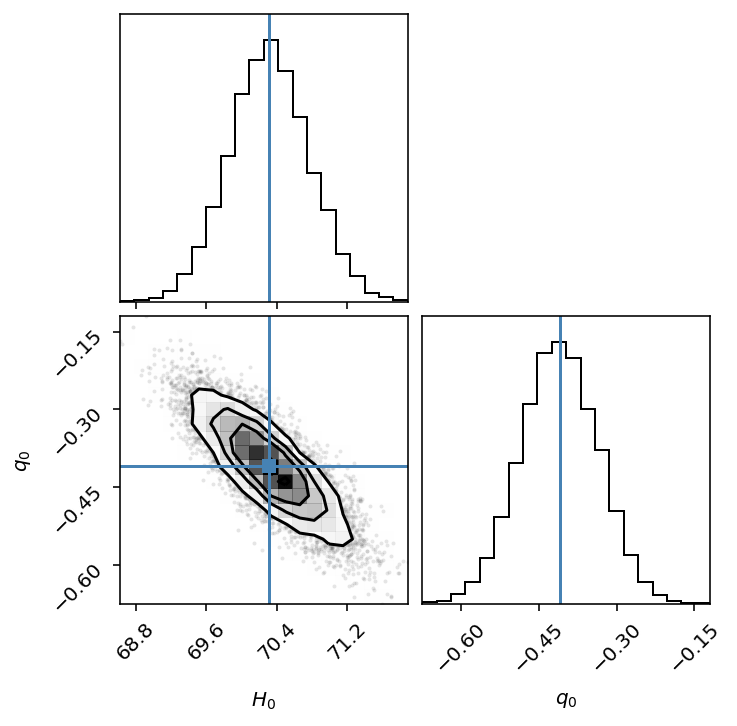

In [19]:
corner.corner(samples_emcee, truths=soln.x, labels=[r"$H_0$", r"$q_0$"]);

### 2.3. Differentiable probabilistic programming approaches with `Pyro`

In [20]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import autoguide
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from tqdm.notebook import tqdm

Now let's try our hand at the probabilistic programming approach. We will use a probabilistic programming language (PPL) framework called `Pyro`, which derives from `PyTorch`. There are two parts to this whole thing:
1. _Define the model_
2. _Perform inference on it_

#### 2.3.1 Defining the model: probabilistic graphical models (PGMs)

In the probabilistic programming spirit, we will define our model as a probabilistic program which encodes the dependencies between random variables. A nice way to visualize complex models are _probabilistic graphical models_ (PGMs) which specify the conditional dependencies between variables, both modeled and observed. 

We will use [`daft`](https://docs.daft-pgm.org/en/latest/api/#the-pgm-object) to visualize our model using a PGM, below. The various probability distributions are represented in **red rectangles**, stochastic random variables in **black circles**, and _observed_ parameters in **double circles**. The conditional independence between a set of variables (here, $N$ different supernova observations) are indicated by placing these inside a large rectangle (called a _plate_).

/usr/local/lib/python3.7/dist-packages/daft.py:848: RuntimeWarning: divide by zero encountered in double_scalars
  dxx2 = self.scale * 0.5 * np.abs(dx / dy) * (np.sign(dx) or 1.0)
/usr/local/lib/python3.7/dist-packages/daft.py:843: RuntimeWarning: divide by zero encountered in double_scalars
  * (np.sign(dy) or 1.0)


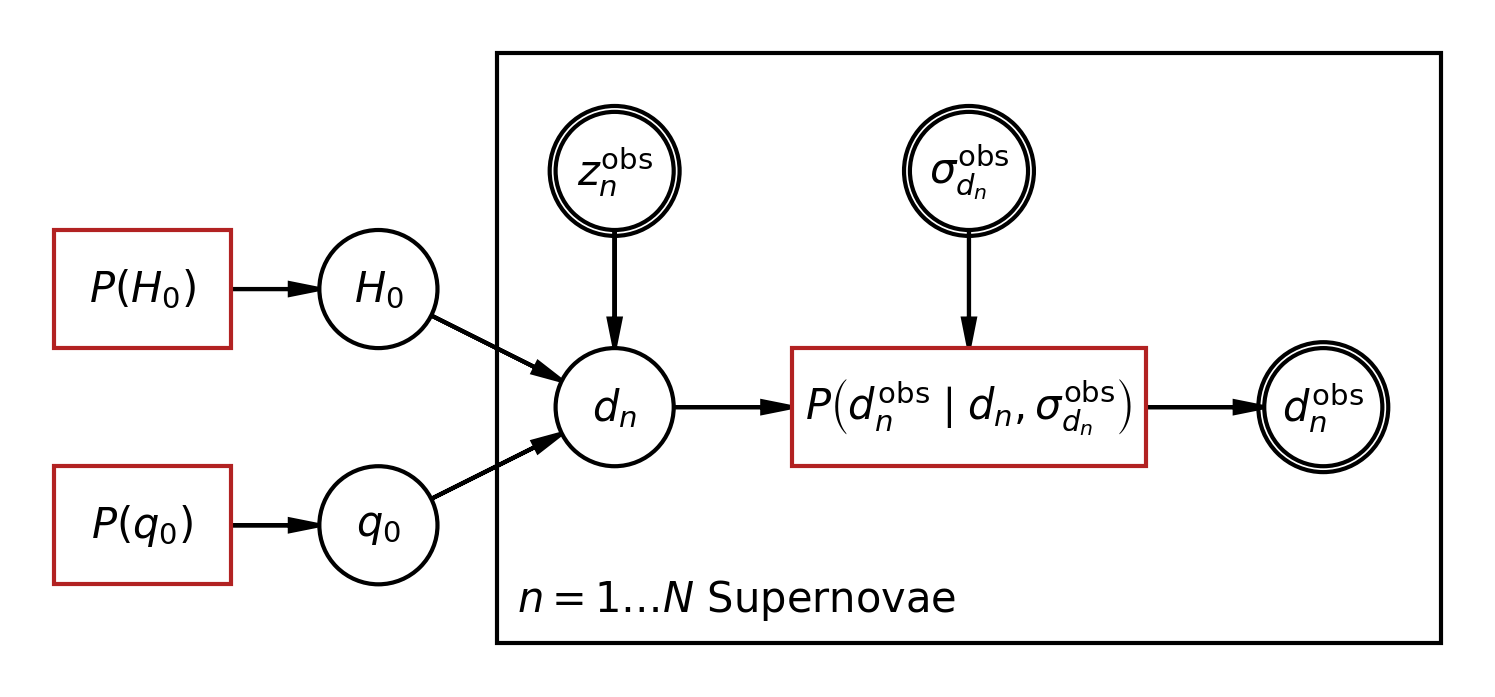

In [21]:
import daft

pgm = daft.PGM(observed_style="outer")

pgm.add_node("P(H_0)", r"$P(H_0)$", -1, 4, shape="rectangle", aspect=1.5, plot_params={"ec":color_default})
pgm.add_node("H_0", r"$H_0$", 0, 4)
pgm.add_node("obs", r"$d^{\mathrm{obs}}_n$", 4, 3.5, observed=True)
pgm.add_node("err", r"$\sigma_{d_n}^\mathrm{obs}$", 2.5, 4.5, observed=True)
pgm.add_node("z", r"$z_{n}^\mathrm{obs}$", 1, 4.5, observed=True)
pgm.add_node("P(d_n|d)", r"$P\left(d^{\mathrm{obs}}_n\mid d_n, \sigma_{d_n}^\mathrm{obs}\right)$", 2.5, 3.5, scale=1, aspect=3.0, shape="rectangle", plot_params={"ec":color_default})
pgm.add_node("d", r"$d_n$", 1, 3.5)

pgm.add_node("P(q)", r"$P(q_0)$", -1, 3, shape="rectangle", aspect=1.5, plot_params={"ec":color_default})
pgm.add_node("q", r"$q_0$", 0, 3)

pgm.add_plate([0.5, 2.5, 4, 2.5], label=r"$n=1\ldots N$ Supernovae")

pgm.add_edge("P(H_0)", "H_0")
pgm.add_edge("H_0", "d")
pgm.add_edge("q", "d")
pgm.add_edge("z", "d")
pgm.add_edge("P(q)", "q")
pgm.add_edge("P(d_n|d)", "obs")
pgm.add_edge("err", "P(d_n|d)")
pgm.add_edge("d", "P(d_n|d)")

pgm.render(dpi=150);

The relevant distributions are asssumed to be as follows:
$$P(H_0) = \mathrm{Unif}(10., 100.)$$
$$P(q_0) = \mathrm{Unif}(-5, 5)$$
$$P\left(d^{\mathrm{obs}}_n\mid d\right) = \mathcal N\left(d^{\mathrm{obs}}_n\mid d_n, \sigma_{d_n}^\mathrm{obs}\right)$$

Defining the model in `Pyro` follows the above PGM closely
- Stochastic random variables are defined with `pyro.sample(name, distribution)`
- Deterministic variables are specified with `pyro.deterministic(name, expression)`
- Conditioning on observations is done using `pyro.sample(name, distribution, obs=observation)`
- Independence between random variables (plating) is specified using `pyro.plate`

In [22]:
def model(x, y, yerr):
    """ Model definition in Pyro
    """
    
    # Stochastic nodes
    H0 = 100 * pyro.sample("h0", dist.Uniform(0.1, 1.0))
    q0 = pyro.sample("q0", dist.Uniform(-5, 5))
    
    # Deterministic node
    y_pred = pyro.deterministic("y_pred", c / H0 * (x + 0.5 * (1 - q0) * x ** 2))
    
    # N different independent observations
    with pyro.plate('observe_data'):
        return pyro.sample("obs", dist.Normal(y_pred, yerr), obs=y)

Having defined the model, we can go on to perform inference on it. In an ideal world, we wouldn't have to think about this part at all---all of the "science" happens in the model definition (arguably). 

This is (unfortunately) not the casel however---choosing how to do inference on complex, high-dimensional models can be hard! Here are some examples using what's built in in `Pyro`:
- Hamiltonian Monte Carlo (HMC)
- Stochastic Variational Inference (SVI)

#### 2.3.2. Inference with Hamiltonian Monte Carlo (HMC)

- Markov Chain Monte Carlo (MCMC) algorithms let us sample from probability distributions---you've seen examples already and implemented the Metroplis-Hastings-[Rosenbluth](https://www.nytimes.com/2021/02/09/science/arianna-wright-dead.html) algorithm. Traditional MCMC algorithms can becomes increasingly inefficient when the parameter space of interest becomes high dimensional. 

- Hamiltonian Monte Carlo (HMC) is a variant of MCMC which uses likelihood _gradient_ information $\nabla_\theta\mathcal L$ in addition to the likelihood $\mathcal L$ and can scale much better to sampling from higher-dimensional distributions. Intuitively, it leverages the "momentum" of the likelihood function in addition to the "position".

- See [this page](https://chi-feng.github.io/mcmc-demo/app.html) for a cool demo and comparison of some sampling algorithms, including HMC and vanilla random walk Metropolis-Hastings.

In [23]:
from IPython.display import IFrame
IFrame('https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=donut', width=750, height=500)

Since we've written down our model in a differentiable framework, we can easily run HMC on it. Now we're getting into _differentiable_ probabilistic programming.

In [24]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=300)

mcmc.run(torch.Tensor(zs[zs < z_max]), torch.Tensor(d[zs < z_max]), torch.Tensor(derr[zs < z_max]))

Sample: 100%|██████████| 2300/2300 [00:44, 51.23it/s, step size=5.76e-01, acc. prob=0.891]


In [25]:
samples_hmc = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
samples_hmc = np.array([samples_hmc['h0'] * 100, samples_hmc['q0']]).T

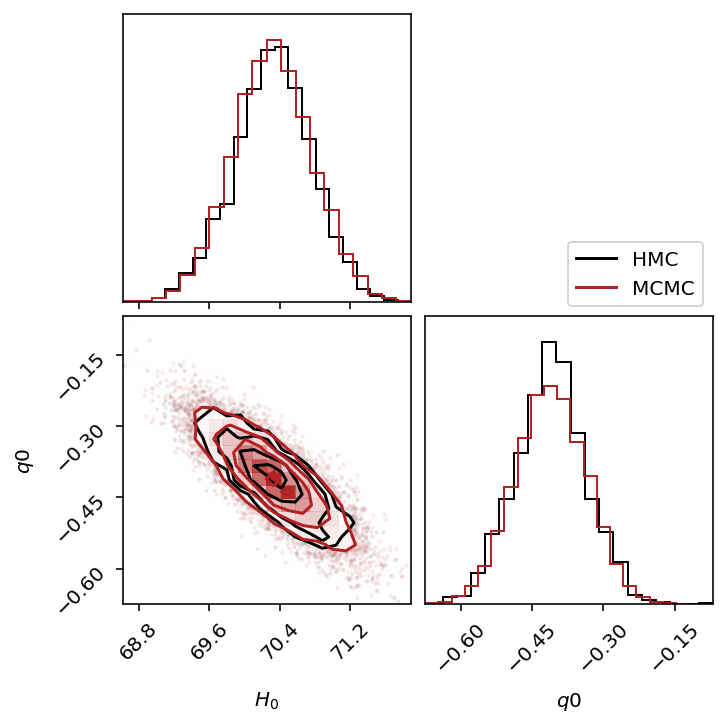

In [26]:
import matplotlib.lines

figure = corner.corner(samples_hmc, labels=[r"$H_0$", r"$q0$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_hmc)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='HMC')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

#### 2.3.3. Inference with Stochastic Variational Inference (SVI)

Other than obtaining samples from the posterior of interest, another method for approximating posterior distributions is to **optimize over a family of functions (called the _variational family_) such that the inferred distribution closely matches the actual posterior.**

The name comes from the _calculus of variations_, where infinitesimal changes to functionals (functions of functions, colloquially) are studied.

- In contrast to the MCMC-style approaches, this turns posterior inference into an optimization problem, rather than a sampling problem. 
- In contrast to the MLE approach (and the deep learning regression approach), rather than finding a single optimal set of parameter values (optimizing over possible numbers), we are now finding a single optimal _distribution_ (optimizing over possible functions).

Let's demonstrate this with plots, arbitrarily showing the "true" posterior as a t-distribution (just for schematic purposes).

In [27]:
from scipy.stats import t, norm

# "True" distribution, just for schematic purposes
x = np.linspace(66, 74, 200)
post_fake = t.pdf(x, df=2, loc=np.mean(samples_emcee[:, 0]), scale=np.std(samples_emcee[:, 0]))

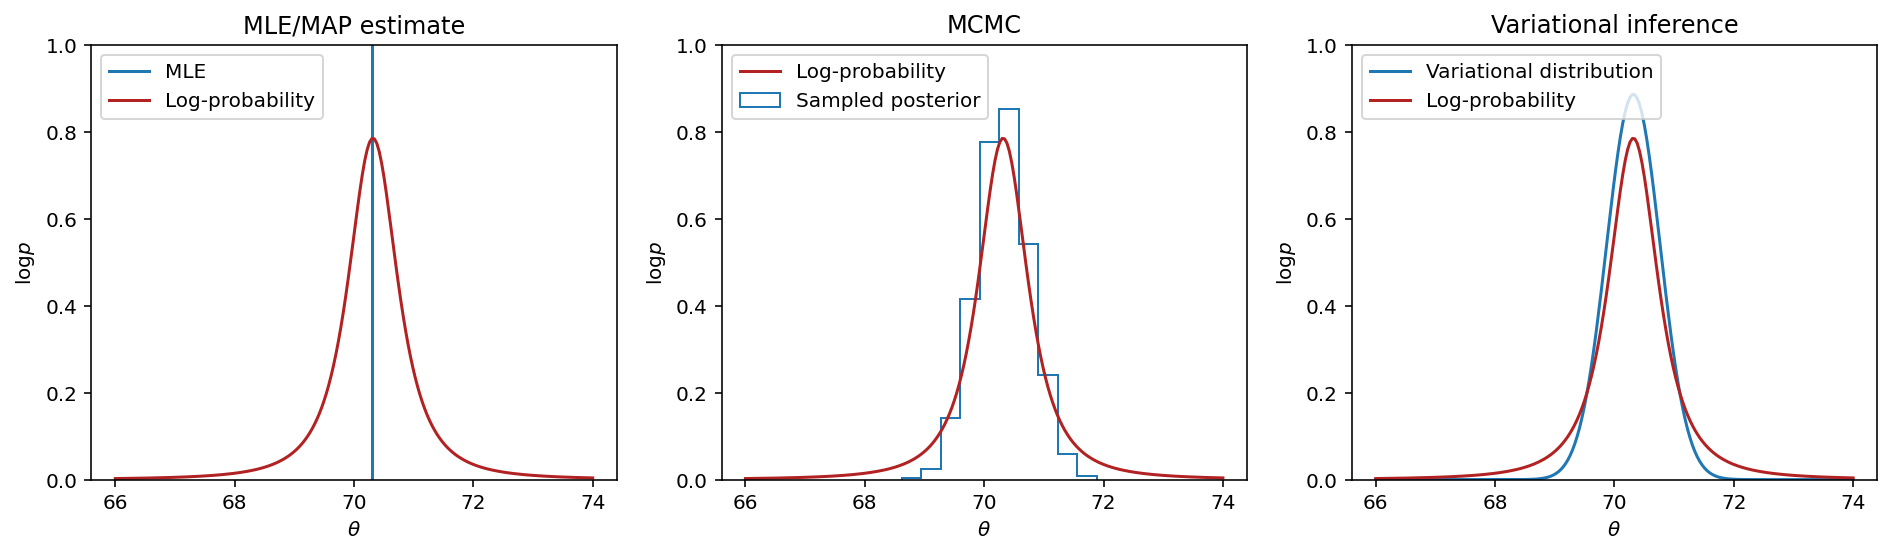

In [28]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(16,4))

ax[0].axvline(soln.x[0], label="MLE")
ax[0].plot(x, post_fake, color=color_default, label="Log-probability")
ax[0].set_title("MLE/MAP estimate")

ax[1].hist(samples_emcee[:, 0], histtype='step', density=True, label="Sampled posterior")
ax[1].plot(x, post_fake, color=color_default, label="Log-probability")
ax[1].set_title("MCMC")

# Arbitrarily-defined Gaussian approximation for the posterior
post_approx = norm.pdf(x, loc=np.mean(samples_emcee[:, 0]), scale=np.std(samples_emcee[:, 0]))
ax[2].plot(x, post_approx, label="Variational distribution")
ax[2].plot(x, post_fake, color=color_default, label="Log-probability")
ax[2].set_title("Variational inference")

[ax[i].set_xlabel(r"$\theta$") for i in range(3)]
[ax[i].set_ylabel(r"$\log p$") for i in range(3)]
[ax[i].set_ylim(0, 1) for i in range(3)]
[ax[i].legend(loc='upper left') for i in range(3)]

Here, we can borrow many of the optimization tricks from deep learning and efficiently scale to much higher dimensions and more complex likelihoods than is possible with sampling algorithms. In _stochastic_ variational inference, we use stochastic gradient descent to optimize over the variational family and target our desired posterior distribution.

We minimize the KL-divergence (a particular measure of closeness between distributions, also known as the "relative entropy") to arrive at the distribution that approximates our posterior well:

$$D_{\mathrm{KL}}(P \| Q)=\int p(x) \log \left(\frac{p(x)}{q(x)}\right) d x$$

with the integral being over the support of $P$. Let's compute $D_{\mathrm{KL}}(P \| Q)$ for a few different Gaussians, again `PyTorch` is doing all of the heavy lifting:

In [29]:
p = torch.distributions.Normal(loc=1,scale=1)
q = torch.distributions.Normal(loc=1.2,scale=0.8)

kl = torch.distributions.kl.kl_divergence(p, q)

print("KL-divergence is {}".format(kl))

KL-divergence is 0.0893564522266388


In [30]:
p = torch.distributions.Normal(loc=1,scale=1)
q = torch.distributions.Normal(loc=2.2,scale=0.8)

kl = torch.distributions.kl.kl_divergence(p, q)

print("KL-divergence is {}".format(kl))

KL-divergence is 1.1831064224243164


How do we do this without already knowing the posterior? While we can't minimize the KL-divergence directly, we can optimize another function that's equal to it up to a constant, called the Evidence Lower BOund (ELBO). This is abstracted away in `Pyro` and we won't go into details, but see [here](https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf) or [here](https://mpatacchiola.github.io/blog/2021/01/25/intro-variational-inference.html) for details and a derivation of this objective function.

Now in addition to the model we need to define the variational family, in `Pyro` parlance known as a _guide_. Let's start with something simple---two different Gaussian distributions modeling the posteriors of the two parameters $H_0$ and $q$.

In [31]:
def guide(x, y, yerr):
    """ A variational distribution defined by two uncorrelated Gaussians
    """
    
    # Means and standard deviations of Gaussians
    locs = pyro.param("loc", 0.5 * torch.ones(2))
    scales = pyro.param("scales", 0.001 * torch.ones(2), constraint=torch.distributions.constraints.positive)
    
    # Parameter samples from variational distribution
    h0 = pyro.sample("h0", dist.Normal(locs[0], scales[0]))
    q0 = pyro.sample("q0", dist.Normal(locs[1], scales[1]))

Now we can use the `Pyro` API to perform gradient descent on the guide parameters, in this case optimizing the means and stds of the two Gaussians.

In [32]:
pyro.clear_param_store()
pyro.set_rng_seed(SEED)

# Set up the optimizer
opt = Adam({'lr':0.01})

# Set up the inference algorithm
svi = SVI(model, guide, opt, loss=Trace_ELBO())

# Number of stochastic gradient descent steps
n_steps = 5000

# Do gradient steps
for step in tqdm(range(n_steps)):
    loss = svi.step(torch.Tensor(zs[zs < z_max]), torch.Tensor(d[zs < z_max]), torch.Tensor(derr[zs < z_max]))

  0%|          | 0/5000 [00:00<?, ?it/s]

After optimization, we can draw samples values from the guide to get a representative posterior. Note that since the modeled posterior in this case is quite simple (just two Gaussians) this could be done analytically. However in general for complex posteriors and high-dimensional distributions we need to sample.

In [33]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000, return_sites=("h0", "q0"))

samples_svi = predictive(torch.Tensor(zs[zs < z_max]), torch.Tensor(d[zs < z_max]), torch.Tensor(derr[zs < z_max]))
samples_svi = np.array([samples_svi['h0'].flatten().numpy() * 100, samples_svi['q0'].flatten().numpy()]).T

Let's plot the samples and compare with what we got from `emcee`:

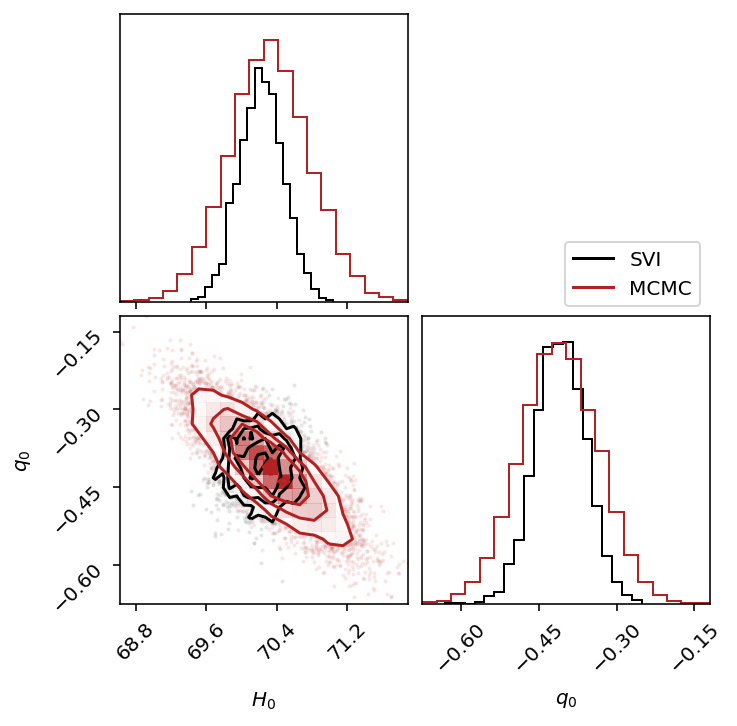

In [34]:
import matplotlib.lines

figure = corner.corner(samples_svi, labels=[r"$H_0$", r"$q_0$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_svi)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='SVI')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

**It looks like the SVI approach doesn't do a great job at modeling the posterior, assuming the MCMC samples to be representative!** Not too surprising perhaps---our variational distribution totally ignored correlations between the two parameters, which clearly exist (the joint posterior is a diagonal ellipse, meaning there are degeneracies between parameters).

Fortunately, we can do better. `Pyro` provides a nice interface for automatically generate variational distributions, called "autoguides". For example, we can use a multivariate normal distribution which additionally fits for the covariances between different parameters, as follows: 

In [35]:
# Define a guide
guide = autoguide.AutoMultivariateNormal(model)

Let's do the optimization again with this guide, draw some samples and plot them.

In [36]:
pyro.clear_param_store()
pyro.set_rng_seed(SEED)

# Set up the optimizer
opt = Adam({'lr':0.01})

# Set up the inference algorithm
svi = SVI(model, guide, opt, loss=Trace_ELBO())

# Number of stochastic gradient descent steps
n_steps = 5000

# Do gradient steps
for step in tqdm(range(n_steps)):
    loss = svi.step(torch.Tensor(zs[zs < z_max]), torch.Tensor(d[zs < z_max]), torch.Tensor(derr[zs < z_max]))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [37]:
predictive = Predictive(model, guide=guide, num_samples=5000, return_sites=("h0", "q0"))

samples_svi = predictive(torch.Tensor(zs[zs < z_max]), torch.Tensor(d[zs < z_max]), torch.Tensor(derr[zs < z_max]))
samples_svi = np.array([samples_svi['h0'].flatten().numpy() * 100, samples_svi['q0'].flatten().numpy()]).T

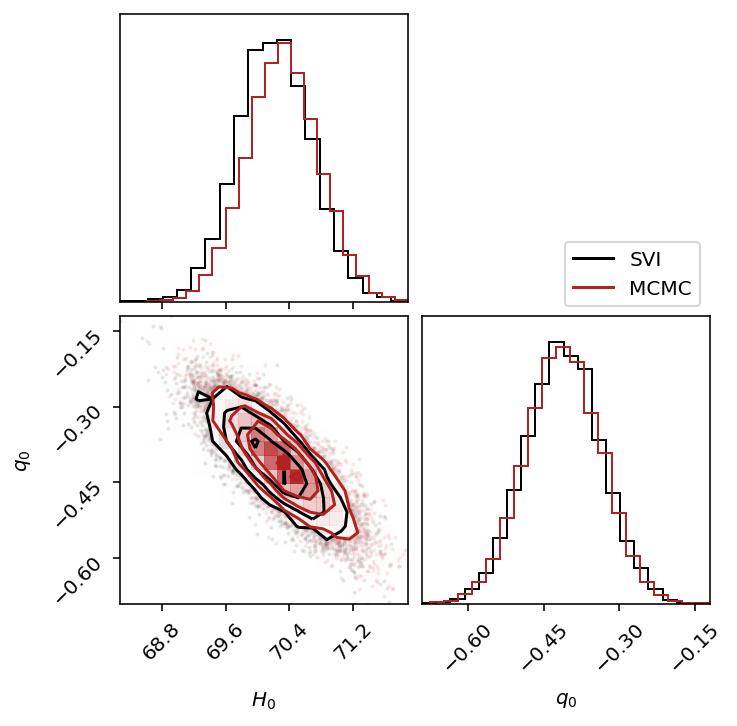

In [38]:
figure = corner.corner(samples_svi, labels=[r"$H_0$", r"$q_0$"])
corner.corner(samples_emcee, fig=figure,weights=np.ones(len(samples_emcee)) / (len(samples_emcee) / len(samples_svi)), color=color_default);

red_line = matplotlib.lines.Line2D([], [], color='firebrick', label='MCMC')
black_line = matplotlib.lines.Line2D([], [], color='k', label='SVI')

plt.legend(handles=[black_line, red_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)

This time the joint posterior is much closer to the MCMC ones, and we can see the covariances between the two components in action.

## 3. Modeling complex distribution: an introduction to normalizing flows

<img src="https://lilianweng.github.io/lil-log/assets/images/normalizing-flow.png" width=800/>

- Gaussians are nice and all, but we often want more flexibility to model complex distributions.
- **Normalizing flows** are a class of models for modeling complicted distributions
- They are based on having a sequence of **invertible, differentiable transformations with tractable Jacobians** (usually parameterized by neural networks) that transform (or deform) a simple distribution, usually a diagonal Gaussian to the complex distribution.

<img src="https://raw.githubusercontent.com/smsharma/smsharma/master/transformation.png" alt="Transform" width="640"/>

Suppose we have 
- Two sets of random variables $z, \theta \in \mathbb R^d$ with corresponding probability densities $z\sim p_z(z)$ and $\theta\sim p(\theta)$ 
- A transformation $\theta = T(z)$.

The **change of variables theorem** relates the two probability densities:

$$p(\theta )=p_z\left(T^{-1}(\theta )\right)\left|\operatorname{det} {J}_{T^{-1}}(\theta )\right|$$

where ${J}_{T^{-1}}(\theta)$ is the determinant of the Jacobian of the inverse transformation and quantifies local changes in "volume" during the transformation.

$${J}_{T^{-1}}(\theta)=\left[\begin{array}{ccc}
\frac{\partial z_{1}(\theta)}{\partial \theta_{1}} & \cdots & \frac{\partial z_{1}(\theta)}{\partial \theta_{d}} \\
\vdots & \ddots & \vdots \\
\frac{\partial z_{d}(\theta)}{\partial \theta_{1}} & \cdots & \frac{\partial z_{d}(\theta)}{\partial \theta_{d}}
\end{array}\right]$$

See, e.g., [this blog post](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html) (where the schematic above is from) for details on normalizing flows, as well as different ways flows are constructed and parameterized.

### 3.1. Defining, sampling, and evaluating a flow

In [39]:
input_dim = 2 

# Specifies the base distribution z ~ N(0,I) as a diagonal Gaussian
dist_z = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))

# Defines the Transformation 
T = pyro.distributions.transforms.affine_autoregressive(input_dim=input_dim, hidden_dims=[32, 32])

# Creates a new distribution where the based distribution is transformed using the flow transformation `T`. 
dist_theta = dist.TransformedDistribution(dist_z, [T])

We can compute the log-probability $\log p(\theta_0)$ of a new set of points $\theta_0$ . Think of this as transforming the new set of points into the base distribution (the Gaussian) and computing the log-probability there.

In [40]:
theta = torch.Tensor([1.,2.])
dist_theta.log_prob(theta)

tensor(-4.1483, grad_fn=<AddBackward0>)

And we can sample from the flow, $\theta\sim p(\theta)$. Think of this as sampling from the base distribution (the Gaussian), and then transforming each sample into the target distribution.

In [41]:
dist_theta.sample((8, input_dim))  # Draw 8 samples from the flow

tensor([[[ 1.6798, -1.0822],
         [ 0.8720,  1.1329]],

        [[ 0.1780, -1.9252],
         [-0.2638,  1.3021]],

        [[-2.0602,  0.0947],
         [ 0.6527,  0.9820]],

        [[-0.8896,  2.0840],
         [-2.0671,  0.4259]],

        [[-0.0166, -0.1953],
         [-1.5683, -1.0100]],

        [[ 1.7501, -0.6752],
         [-0.8176,  0.1938]],

        [[ 0.5306,  1.4614],
         [ 0.6052, -0.6742]],

        [[ 1.7761, -0.6750],
         [ 0.6710, -0.5261]]])

The flow transformation, being parameterized by neural networks, has more parameters than our previous distributions:

In [42]:
param_count = 0 
for param in T.parameters():
    param_count += len(param)
    
print("The flow transformation has {} parameters".format(param_count))

The flow transformation has 136 parameters


Let's try and train the normalizing flow we have defined to model a simple toy distribution---a 2-component Gaussian mixture in 2 dimensions.

In [43]:
from scipy.stats import multivariate_normal
import seaborn as sns

In [44]:
n_components = 2  # Number of mixture components
weights_mixture = [0.3, 0.7]  # Relative weights of mixture components
locs = [[1,1],[-1,-1]]  # Means of mixture components
scales = [[0.1, 0.5] for _ in range(n_components)]  # stds of mixture components 

def simulator_gmm():
    """ Draw samples from Gaussian mixture model
    """
    idx_comp = np.random.choice(np.arange(n_components), p=weights_mixture)
    return multivariate_normal(mean=locs[idx_comp], cov=scales[idx_comp]).rvs()

In [45]:
# Sample from the GMM
samples = np.array([simulator_gmm() for _ in range(10000)])

Text(0.5, 1.0, 'True (target) density')

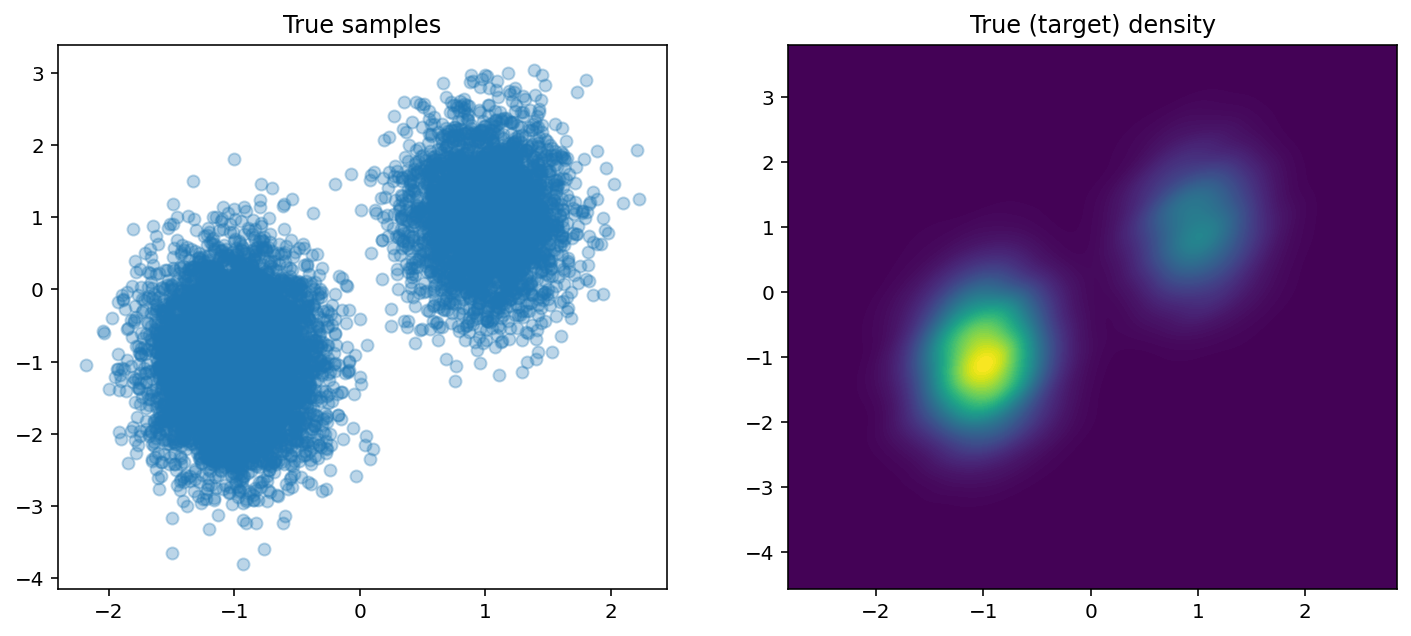

In [46]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,5))

ax[0].scatter(*samples.T, alpha=0.3)
ax[0].set_title("True samples")

sns.kdeplot(x=samples.T[0], y=samples.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[1])
ax[1].set_title("True (target) density")

### 3.2. Training a normalizing flow

Let's write a convenience function to train the parameter of the neural network

In [47]:
def train_flow(dataset, params, batch_size=64, n_steps=5001, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    dataset = torch.tensor(dataset)
    optimizer = torch.optim.Adam(params, lr=lr)
    
    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(dataset.shape[0], batch_size) 
        loss = -dist_theta.log_prob(dataset[idxs,:]).mean()
        
        loss.backward()
        optimizer.step()
        dist_theta.clear_cache()

        if i_step % 200 == 0: print('Step: {}; Loss: {}'.format(i_step, loss.item()))

In [48]:
# Train the normalizing flow
train_flow(torch.Tensor(samples), params = T.parameters(), n_steps=5000, batch_size=64)   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


  0%|          | 0/5000 [00:00<?, ?it/s]

Step: 0; Loss: 3.0118465423583984
Step: 200; Loss: 2.5855488777160645
Step: 400; Loss: 2.4229698181152344
Step: 600; Loss: 2.574429988861084
Step: 800; Loss: 2.3486924171447754
Step: 1000; Loss: 2.4571540355682373
Step: 1200; Loss: 2.4482481479644775
Step: 1400; Loss: 2.4129233360290527
Step: 1600; Loss: 2.50543212890625
Step: 1800; Loss: 2.5523722171783447
Step: 2000; Loss: 2.375135660171509
Step: 2200; Loss: 2.5015194416046143
Step: 2400; Loss: 2.4537692070007324
Step: 2600; Loss: 2.2624785900115967
Step: 2800; Loss: 2.3906936645507812
Step: 3000; Loss: 2.215953826904297
Step: 3200; Loss: 2.3427793979644775
Step: 3400; Loss: 2.4437694549560547
Step: 3600; Loss: 2.6946053504943848
Step: 3800; Loss: 2.4472086429595947
Step: 4000; Loss: 2.5217080116271973
Step: 4200; Loss: 2.4428200721740723
Step: 4400; Loss: 2.3912603855133057
Step: 4600; Loss: 2.4190804958343506
Step: 4800; Loss: 2.523003101348877


In [49]:
# Draw 5000 samples from the base distribution as well as the normalizing flow
samples_base = np.array([dist_z.sample().detach().numpy() for _ in range(5000)])
samples_test = np.array([dist_theta.sample().detach().numpy() for _ in range(5000)])

Let's plot the density of samples from our learned flow, as well as the base distribution and true target distribution.

[(-2.75, 2.75), (-2.75, 2.75), (-2.75, 2.75)]

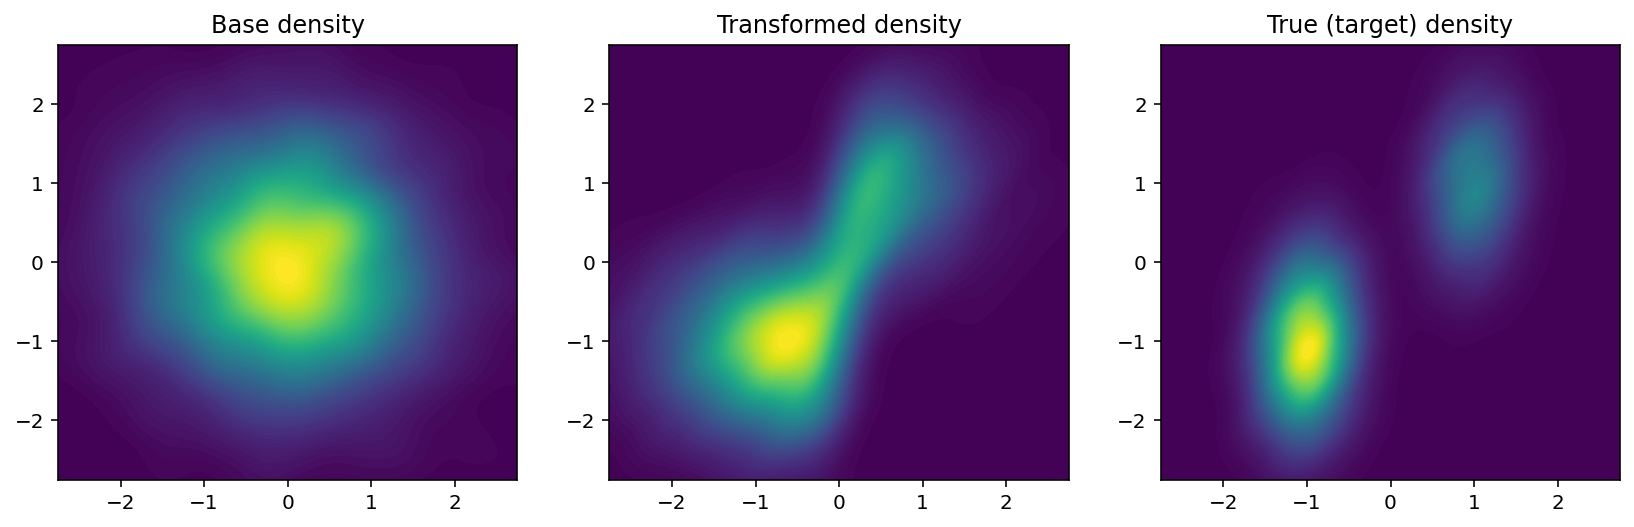

In [50]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14,4))

sns.kdeplot(x=samples_base.T[0], y=samples_base.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[0])
ax[0].set_title("Base density")

sns.kdeplot(x=samples_test.T[0], y=samples_test.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[1])
ax[1].set_title("Transformed density")

sns.kdeplot(x=samples.T[0], y=samples.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[2])
ax[2].set_title("True (target) density")

[ax[i].set_xlim(-2.75, 2.75) for i in range(3)]
[ax[i].set_ylim(-2.75, 2.75) for i in range(3)]

### 3.3. Stacking together several flow

In [51]:
input_dim = 2 
n_flows = 6  # Number of flow transformations to be chained

# Base distribution
dist_z = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))

# Defines the Transformation 
T = [pyro.distributions.transforms.affine_autoregressive(input_dim=input_dim, hidden_dims=[32, 32]) for _ in range(n_flows)]

# Creates a distribution object which is Z transformed with the transformation T 
dist_theta = dist.TransformedDistribution(dist_z, T)

In [52]:
params = []
param_count = 0

for T_i in T:
    params += list(T_i.parameters())
    
    for param in T_i.parameters():
        param_count += len(param)
    
print("The flow transformation has {} parameters".format(param_count))

The flow transformation has 816 parameters


This time we have still more learnable parameters.

In [53]:
train_flow(torch.Tensor(samples), params=params, n_steps=5000, batch_size=64)   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


  0%|          | 0/5000 [00:00<?, ?it/s]

Step: 0; Loss: 3.0415797233581543
Step: 200; Loss: 1.9363667964935303
Step: 400; Loss: 1.9858583211898804
Step: 600; Loss: 2.075194835662842
Step: 800; Loss: 2.007749080657959
Step: 1000; Loss: 1.8696959018707275
Step: 1200; Loss: 2.066398859024048
Step: 1400; Loss: 2.085157871246338
Step: 1600; Loss: 1.9840813875198364
Step: 1800; Loss: 2.042930841445923
Step: 2000; Loss: 2.0427536964416504
Step: 2200; Loss: 2.079313039779663
Step: 2400; Loss: 1.7917542457580566
Step: 2600; Loss: 2.020453453063965
Step: 2800; Loss: 1.987554669380188
Step: 3000; Loss: 1.9172565937042236
Step: 3200; Loss: 1.8923031091690063
Step: 3400; Loss: 1.9353020191192627
Step: 3600; Loss: 1.9073717594146729
Step: 3800; Loss: 1.9671945571899414
Step: 4000; Loss: 2.081040859222412
Step: 4200; Loss: 2.0069494247436523
Step: 4400; Loss: 2.245495319366455
Step: 4600; Loss: 1.8668063879013062
Step: 4800; Loss: 2.2056732177734375


In [54]:
samples_test = np.array([dist_theta.sample().detach().numpy() for _ in range(5000)])

[(-2.75, 2.75), (-2.75, 2.75), (-2.75, 2.75)]

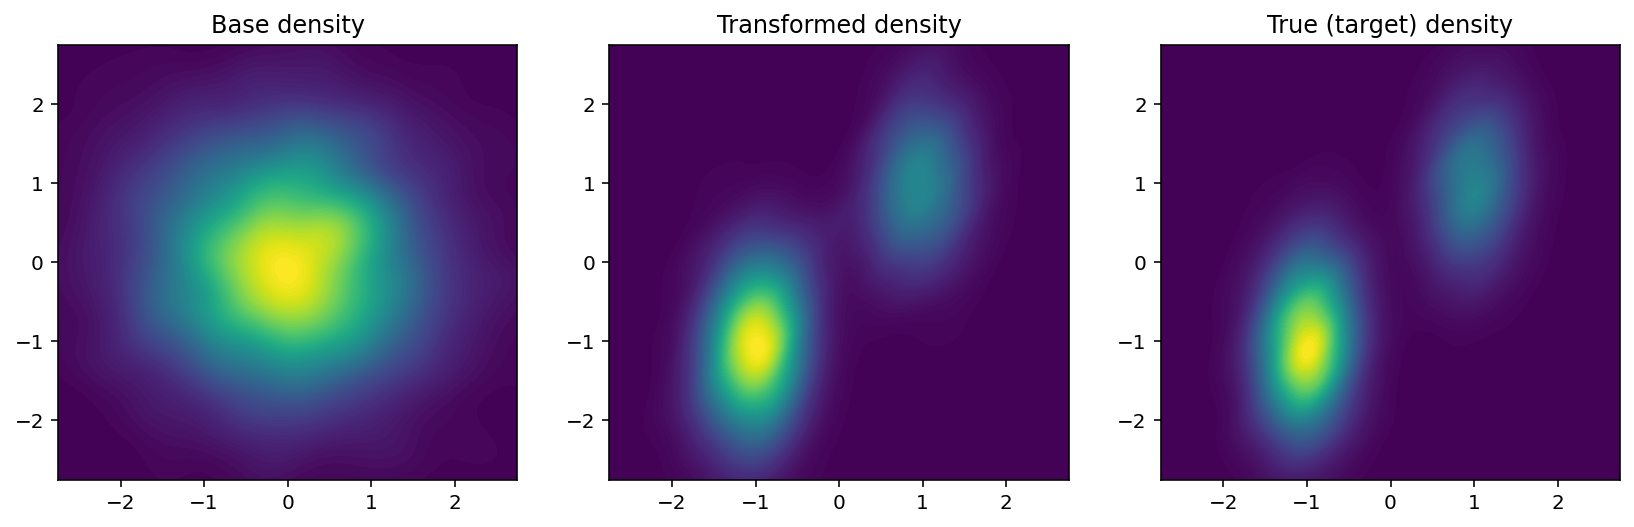

In [55]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14,4))

sns.kdeplot(x=samples_base.T[0], y=samples_base.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[0])
ax[0].set_title("Base density")

sns.kdeplot(x=samples_test.T[0], y=samples_test.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[1])
ax[1].set_title("Transformed density")

sns.kdeplot(x=samples.T[0], y=samples.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[2])
ax[2].set_title("True (target) density")

[ax[i].set_xlim(-2.75, 2.75) for i in range(3)]
[ax[i].set_ylim(-2.75, 2.75) for i in range(3)]

The transformed distribution matches the target density much better now!

For fun, we can plot the density returned by the 6 individual transformation in order to see how the probability density _flows_ from the base distribution to the target distribution.

[(-2.75, 2.75),
 (-2.75, 2.75),
 (-2.75, 2.75),
 (-2.75, 2.75),
 (-2.75, 2.75),
 (-2.75, 2.75),
 (-2.75, 2.75)]

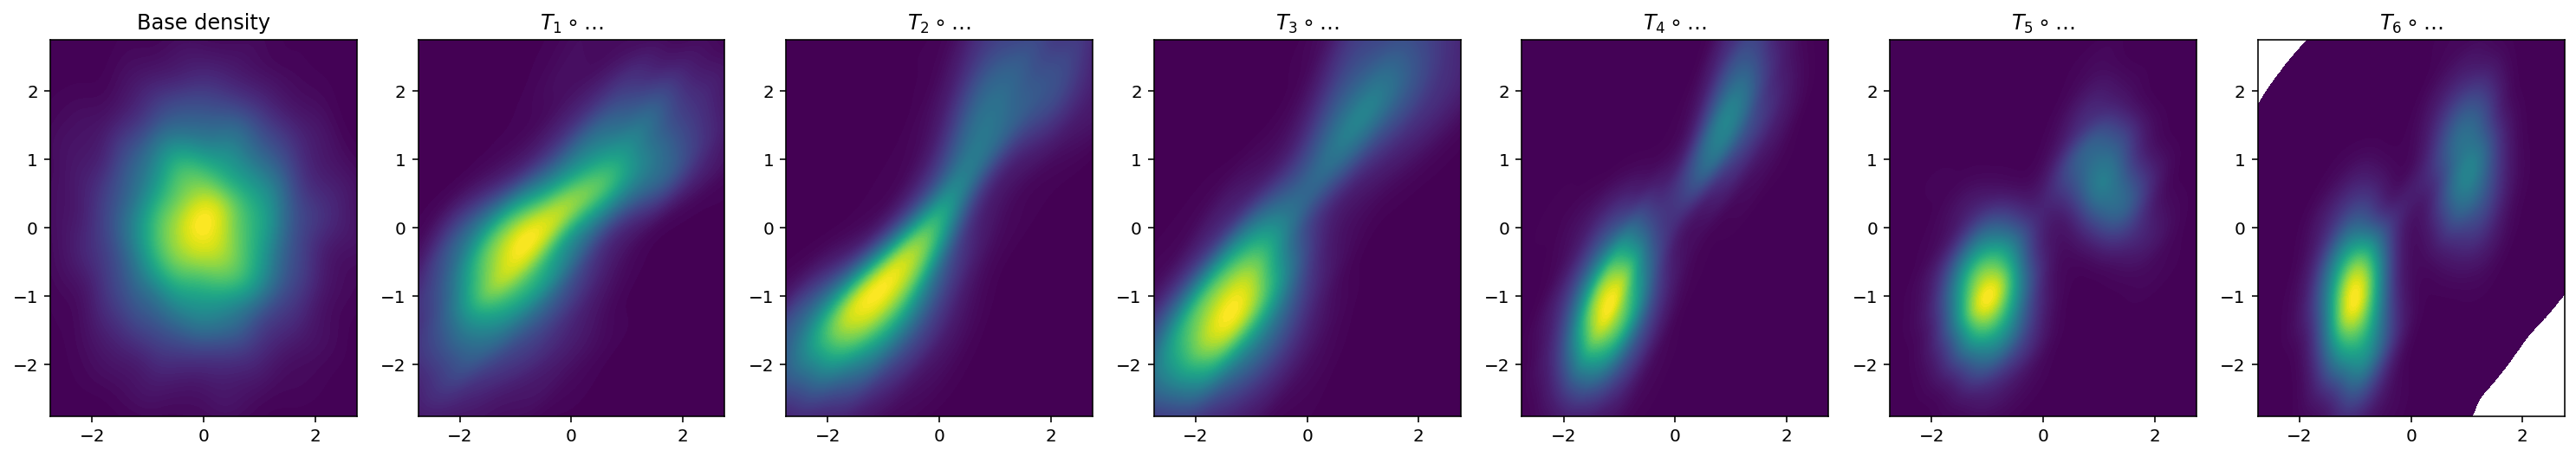

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=n_flows + 1, figsize=(26,4))

for i in range(n_flows + 1):
    
    dist_test = dist.TransformedDistribution(dist_z, [T[j] for j in range(i)])

    samples_test = np.array([dist_test.sample().detach().numpy() for _ in range(5000)])
    sns.kdeplot(x=samples_test.T[0], y=samples_test.T[1], fill=True, levels=100, cmap='viridis', thresh=0, ax=ax[i])
    
    if i == 0:
        ax[i].set_title("Base density")
    else:
        ax[i].set_title(r"$T_{} \circ\ldots$".format(i))

[ax[i].set_xlim(-2.75, 2.75) for i in range(n_flows + 1)]
[ax[i].set_ylim(-2.75, 2.75) for i in range(n_flows + 1)]

In `Pyro`, the variational distribution can be set to a particular type of normalizing flow (an _inverse autoregressive flow_, IAF) by leveraging the Autoguide functionality:

In [57]:
guide = autoguide.AutoIAFNormal(model)

## 4. Some real-world applications

The example we've been working with (Hubble inference) is fairly straightforward---there isn't much of an advantage to taking a probabilistic programming approach, other than exposing the underlying philosophy.

### 4.1. A hierarchical approach to Hubble constant inference

- Real-work scientific analyses and forward models can be quite a bit more complex---take a look at the PGM below, from this nice paper (https://arxiv.org/abs/1707.00007) which also aims to measure the Hubble constant (you can see it in the top right part of the plot) using supernova and other observations, but in a much move involved manner. 
- In a case like this, a probabilistic description of the model can make analyses significantly more pleasant.

<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/476/3/10.1093_mnras_sty418/1/sty418fig3.jpeg?Expires=1645818239&Signature=rdscjqUw36B1HYnu7IvpqBgUdJYnkeZIkiUikbjxqb9JlQOB28aPE-dJN6-KC7T7Qo3WCwsfPuF0CkB90b5CVfcXkDj2kqEwJjMzee5BxYC-ma2T9x4GZuxx1u3MeXp8dJGChLuwji3yS937UbJhdgTyZ~rkzl4cSwYcvHL4r~Zb33Xe1D3s3ptvNiaIzLIDfYThOpDmZxQmwhpV7Ad9EwOsA-EqvFTYU1hx5WSzsdLG1H0fL4ksOABcn3MAEpjlVXOSAbq4-Z-Gy8iC3Jg98SqkfStcNWp2BPTQcGq-wznn9EVEdRirl5ougdI0nOVUG6~GjZ2YkrlGzeZGC2Oyiw__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" width=1024/>

### 4.2. Optimizing detector design

- We have focused on using probabilistic programming for parameter estimation. However, by being able to define a scientific workflow in terms in a composable way, we can optimize many other parts of the chain.
- A particular application of interest is **optimizing parameters of a detector to maximized performance (for a given scientific goal) subject to constraints (for example, a fixed budget)**
- Example below via the MODE collaboration (https://mode-collaboration.github.io/docs/mode_npni_preprint.pdf)

<img src="https://gilesstrong.github.io/website/images/posts/2021-09-10-Differentiable-Programming-and-MODE/media/image2.png" width=640/>